In [34]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os

import warnings
warnings.filterwarnings('ignore')

In [49]:
file_dir = "../rivertile"
proj_str = "+proj=eqc +lon_0=105.2050781 +lat_ts=14.5376876 +datum=WGS84 +units=m +no_defs"  # obtained from https://projectionwizard.org/# by selecting the region of interest (SE Asia) and chose `Equidistant` option

files =  [os.path.join(file_dir, fn) for fn in os.listdir(file_dir) if fn.endswith('_nodes.shp')]


# Let's plot one of these files to look at how they are represented
fn1 = files[0]
gdf1 = gpd.read_file(fn1)

nodata_val = -999999999999.0
gdf1_filtered = gdf1[gdf1['wse'] != nodata_val]
gdf1_filtered['date'] = gdf1_filtered['time_str'].apply(lambda val: pd.to_datetime(val.split('T')[0]))
gdf1_filtered.head()


,reach_id,node_id,time,time_tai,time_str,lat,lon,lat_u,lon_u,river_name,...,p_wse_var,p_width,p_wid_var,p_dist_out,p_length,p_dam_id,p_n_ch_max,p_n_ch_mod,geometry,date
504,44250000201,44250000200451,6.915947e+08,6.915946e+08,2021-11-30T13:3745Z,15.035078,105.863843,0.000007,0.000046,*,...,0.000347,779.0,218.250000,870822.546,211.430920,0,1,1,POINT (105.86323 15.03456),2021-11-30
505,44250000201,44250000200461,6.915947e+08,6.915946e+08,2021-11-30T13:3745Z,15.036048,105.860900,0.000004,0.000023,*,...,0.000306,918.0,5771.061224,871038.950,216.404335,0,1,1,POINT (105.86248 15.03633),2021-11-30
506,44250000201,44250000200471,6.915947e+08,6.915946e+08,2021-11-30T13:3745Z,15.038595,105.864219,0.000003,0.000020,*,...,0.000000,898.0,560.222222,871235.854,196.903696,0,2,1,POINT (105.86221 15.03809),2021-11-30
507,44250000201,44250000200481,6.915947e+08,6.915946e+08,2021-11-30T13:3745Z,15.040455,105.862183,0.000004,0.000026,*,...,0.000000,853.0,1090.640000,871427.948,192.093782,0,1,1,POINT (105.86122 15.03952),2021-11-30
508,44250000201,44250000200491,6.915947e+08,6.915946e+08,2021-11-30T13:3745Z,15.039840,105.859207,0.000004,0.000029,*,...,0.000000,801.0,2716.560000,871616.608,188.660753,0,1,1,POINT (105.85984 15.04058),2021-11-30


Text(0.5, 1.0, 'Observation Date: 2021-11-30 00:00:00')

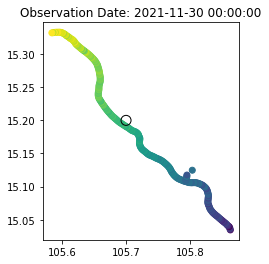

In [50]:
virtual_station = Point(105.7, 15.2)
virtual_station_gdf = gpd.GeoDataFrame({'name': ['virtual station 1']}, geometry=[virtual_station], crs='EPSG:4326')

obs_date = gdf1_filtered['date'].iloc[0]

gdf1_filtered.plot('wse')  # plotting the WSE from SWOT
plt.scatter(virtual_station.x, virtual_station.y, marker='o', s=100, ec='black', fc='none')
plt.title(f"Observation Date: {obs_date}")

In [51]:
height = virtual_station_gdf.sjoin_nearest(gdf1_filtered)
height

,name,geometry,index_right,reach_id,node_id,time,time_tai,time_str,lat,lon,...,p_wse,p_wse_var,p_width,p_wid_var,p_dist_out,p_length,p_dam_id,p_n_ch_max,p_n_ch_mod,date
0,virtual station 1,POINT (105.70000 15.20000),640,44250000231,44250000230311,6.915947e+08,6.915946e+08,2021-11-30T13:3747Z,15.193011,105.694622,...,90.0,0.0,1627.0,158.56,898229.097,181.794665,0,2,2,2021-11-30


(15.18, 15.22)

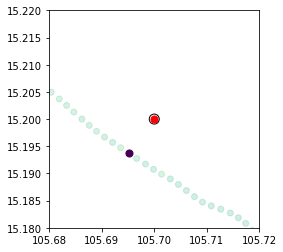

In [52]:
f, ax = plt.subplots()

gdf1_filtered.plot('wse', ax=ax, alpha=0.2)  # plotting the WSE from SWOT
gdf1_filtered.loc[gdf1_filtered['node_id'].values==height['node_id'].values].plot('wse', s=50, ax=ax)
ax.scatter(virtual_station.x, virtual_station.y, marker='o', s=100, ec='black', fc='none')
ax.scatter(height.geometry.x, height.geometry.y, marker='o', s=50, c='red')
plt.xlim(105.68, 105.72)
plt.ylim(15.18, 15.22)
# plt.title(f"Observation Date: {obs_date}")

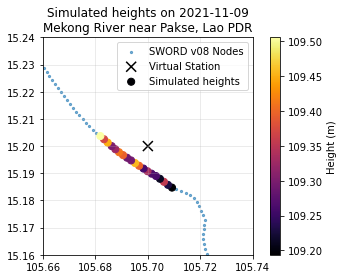

In [109]:
def get_height(fn, virtual_station_location, proj_str, max_distance=2e3, verbose=False):
    """Returns the height using the node nearest to the virtual station

    Args:
        fn (str): file path of the _node.shp file
        virtual_station_location (shpely.geoemtry.Point): Point specifying the location of the virtual station
        proj_str (str): A `proj` string or EPSG code in `EPSG:<code>` format that will be used to transform the datasets into a consistent projection. The projection should preserve the distance for the region of interest
        max_distance (float): Maximum distance up to which the nodes will be considered in meters. Default = 2000 m
        verbose (bool): if True, the result of the spatial join will be returned, else the average height value will be returned. Default = False

    Returns:
        tuple(pd.Timestamp, ): _description_
    """
    gdf1 = gpd.read_file(fn)
    orig_proj = gdf1.crs
    gdf1 = gdf1.to_crs(proj_str)

    nodata_val = -999999999999.0
    gdf1_filtered = gdf1[gdf1['wse'] != nodata_val]
    gdf1_filtered['date'] = gdf1_filtered['time_str'].apply(lambda val: pd.to_datetime(val.split('T')[0]))

    virtual_station_gdf = gpd.GeoDataFrame({'name': ['virtual station 1']}, geometry=[virtual_station_location], crs='EPSG:4326').to_crs(proj_str)

    obs_date = gdf1_filtered['date'].iloc[0]

    # Join based on spatial distance
    height = gdf1_filtered.sjoin_nearest(virtual_station_gdf, max_distance=max_distance, distance_col='distance')
    
    if verbose:
        return obs_date, height.to_crs(orig_proj)
    else:
        h = height['wse'].mean()
        return obs_date, h

# Let's try to get the height for another date
d, h = get_height(files[1], virtual_station, proj_str, verbose=True)

# Let's plot
f, ax = plt.subplots()

gdf1_filtered.plot(ax=ax, alpha=0.6, label='SWORD v08 Nodes', markersize=5)  # plotting the WSE from SWOT
# gdf1_filtered.loc[gdf1_filtered['node_id'].values==height['node_id'].values].plot('wse', s=50, ax=ax)
ax.scatter(virtual_station.x, virtual_station.y, marker='x', s=100, ec='black', fc='none', label='Virtual Station')
h.plot('wse', marker='o', s=50, cmap='inferno', ax=ax, legend=True, legend_kwds={'label': 'Height (m)'}, label='Simulated heights')
ax.set_xlim(105.66, 105.74)
ax.set_ylim(15.16, 15.24)
ax.grid(alpha=0.3)
ax.set_title(f"Simulated heights on {d.strftime('%Y-%m-%d')}\nMekong River near Pakse, Lao PDR")
ax.legend()

In [110]:
# We can now get the time-series
dates = []
heights = []
for fn in files:
    print(f"Processing {fn}")
    date, h = get_height(fn, virtual_station, proj_str)

    dates.append(date)
    heights.append(h)

virtual_station_heights = pd.DataFrame({'date': dates, 'height': heights}).set_index('date')
virtual_station_heights.head()

Processing ../rivertile/SWOT_L2_HR_RiverTile_016_577_181L_20211130T133743_20211130T133754_Dx0000_01_nodes.shp
Processing ../rivertile/SWOT_L2_HR_RiverTile_015_577_181L_20211109T165245_20211109T165257_Dx0000_01_nodes.shp
Processing ../rivertile/SWOT_L2_HR_RiverTile_017_090_128L_20211204T003909_20211204T003920_Dx0000_01_nodes.shp
Processing ../rivertile/SWOT_L2_HR_RiverTile_020_090_128L_20220204T145401_20220204T145411_Dx0000_01_nodes.shp
Processing ../rivertile/SWOT_L2_HR_RiverTile_014_090_128R_20211002T102418_20211002T102429_Dx0000_01_nodes.shp
Processing ../rivertile/SWOT_L2_HR_RiverTile_018_090_128L_20211224T212407_20211224T212417_Dx0000_01_nodes.shp
Processing ../rivertile/SWOT_L2_HR_RiverTile_016_090_128R_20211113T035412_20211113T035423_Dx0000_01_nodes.shp
Processing ../rivertile/SWOT_L2_HR_RiverTile_021_090_128R_20220225T113858_20220225T113908_Dx0000_01_nodes.shp
Processing ../rivertile/SWOT_L2_HR_RiverTile_015_090_128R_20211023T070915_20211023T070926_Dx0000_01_nodes.shp
Processing

,height
date,
2021-11-30,109.336628
2021-11-09,109.331942
2021-12-04,NaN
2022-02-04,NaN
2021-10-02,109.308794


<AxesSubplot:xlabel='date'>

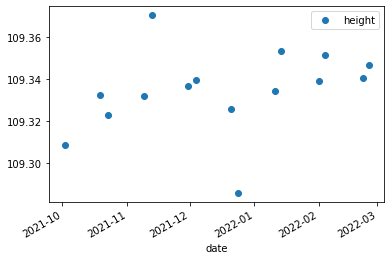

In [111]:
virtual_station_heights.plot(marker='o', linewidth=0)